#Walmart Recruiting - Store Sales Forecasting

#The Problem:

One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

We are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.

We need to predict the final sales in the week given the features.

#DATA:

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

features.csv

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

#Evaluation Metric:

We will use weighted mean absolute error (WMAE) for the evaluation:

More on the metric here: 

https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/evaluation

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.model_selection import train_test_split

import pandas_profiling as pdp

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"utkarshpd","key":"f93925c772ca6d01a26796ec0bef5c9a"}'}

In [0]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 49.4MB/s]
  0% 0.00/220k [00:00<?, ?B/s]
100% 220k/220k [00:00<00:00, 72.2MB/s]
  0% 0.00/532 [00:00<?, ?B/s]
100% 532/532 [00:00<00:00, 539kB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 76.8MB/s]
  0% 0.00/2.47M [00:00<?, ?B/s]
100% 2.47M/2.47M [00:00<00:00, 81.0MB/s]


In [0]:
#Reading Database 
train = pd.read_csv('/content/train.csv.zip')
feature = pd.read_csv('/content/features.csv.zip')
test = pd.read_csv('/content/test.csv.zip')
stores = pd.read_csv('/content/stores.csv')
sam = pd.read_csv('/content/sampleSubmission.csv.zip')

In [0]:
#Merging information between the data [Train and Test]
dfTrainTmp           = pd.merge(train, stores)
dfTestTmp            = pd.merge(test, stores)   
      
#Merging the feature with the data [Train and Test]
train                = pd.merge(dfTrainTmp, feature)
test                 = pd.merge(dfTestTmp, feature)

In [0]:
#Split the field Date
train['Year']        = pd.to_datetime(train['Date']).dt.year
train['Month']       = pd.to_datetime(train['Date']).dt.month
train['Day']         = pd.to_datetime(train['Date']).dt.day
train['Days']        = train['Month']*30+train['Day'] 

#Converting type of store to numeric
train['Type']        = train['Type'].replace('A',1)
train['Type']        = train['Type'].replace('B',2)
train['Type']        = train['Type'].replace('C',3)
    
#Counting the passend days util the holiday
train['daysHoliday'] = train['IsHoliday']*train['Days']
#Coverting the sales to log scale
train['logSales']    = np.log(4990+train['Weekly_Sales'])

#Same with test data
test['Year']         = pd.to_datetime(test['Date']).dt.year
test['Month']        = pd.to_datetime(test['Date']).dt.month
test['Day']          = pd.to_datetime(test['Date']).dt.day
test['Days']         = test['Month']*30+test['Day']
test['Type']         = test['Type'].replace('A',1)
test['Type']         = test['Type'].replace('B',2)
test['Type']         = test['Type'].replace('C',3)
test['daysHoliday']  = test['IsHoliday']*test['Days']

In [8]:
feature.groupby(["Store"]).head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8008,45,2010-02-05,27.31,2.784,NaN,NaN,NaN,NaN,NaN,181.871190,8.992,False
8009,45,2010-02-12,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,True
8010,45,2010-02-19,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,False
8011,45,2010-02-26,34.89,2.754,NaN,NaN,NaN,NaN,NaN,182.077469,8.992,False


#EDA

####https://www.kaggle.com/yepp2411/walmart-prediction-1-eda-with-time-and-space

      count       mean       std  ...       50%       75%       max
Type                              ...                              
A      22.0  177247.73  49392.62  ...  202406.0  203819.0  219622.0
B      17.0  101190.71  32371.14  ...  114533.0  123737.0  140167.0
C       6.0   40541.67   1304.15  ...   39910.0   40774.0   42988.0

[3 rows x 8 columns]


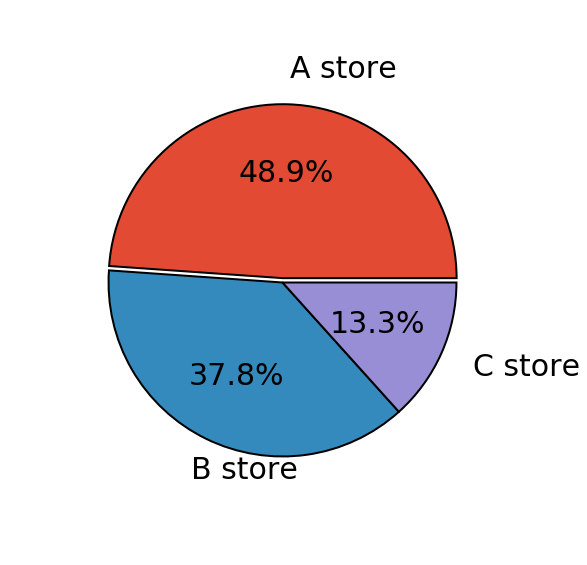

In [0]:
grouped=stores.groupby('Type')
print(grouped.describe()['Size'].round(2))
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=grouped.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion


fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':2}

tprops = {'fontsize':30}


axes.pie(sizes,
        labels=labels,
        explode=(0.02,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

**Type A stores are the maximum among the three and Type C is the minimum.**

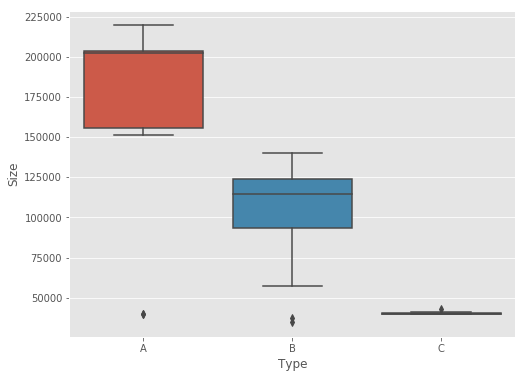

In [0]:
data = pd.concat([stores['Type'], stores['Size']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=data)

**we can infer that type A store is the largest store and C is the smallest in sizes**

**There is no overlapped area in size among A, B, and C.**

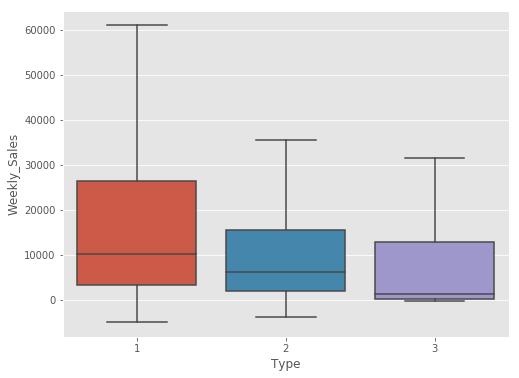

In [0]:
data = pd.concat([train['Type'], train['Weekly_Sales']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=data, showfliers=False)

**Type A stores has highest Weekly Sales as comapred to other stores.**

**That means stores with more sizes have higher sales record**

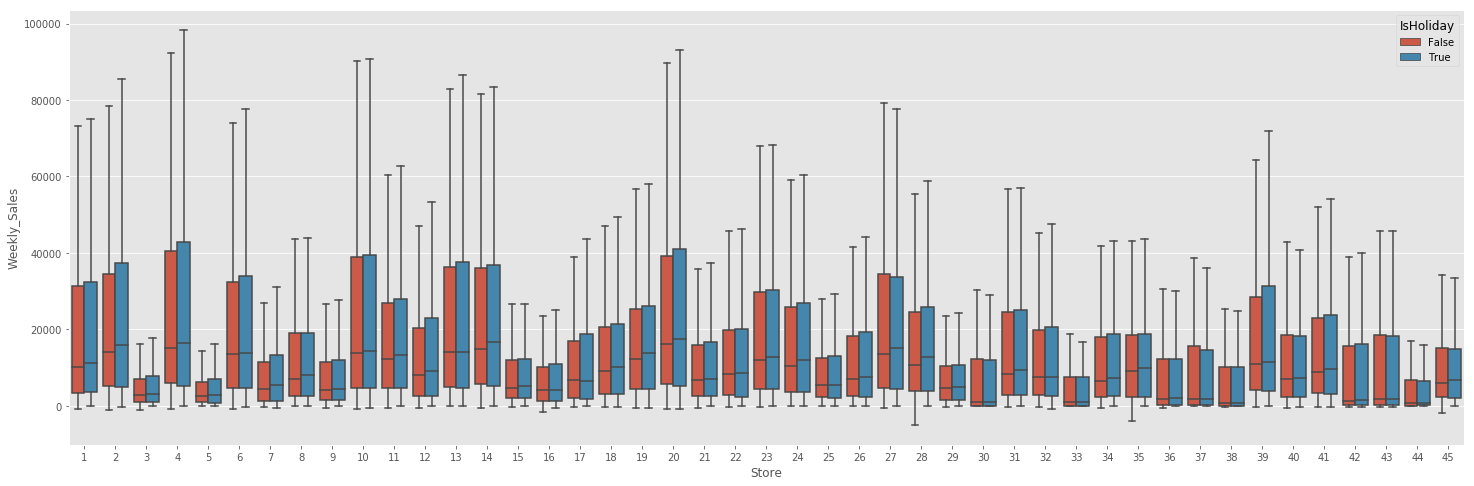

In [0]:
data = pd.concat([train['Store'], train['Weekly_Sales'], train['IsHoliday']], axis=1)
f, ax = plt.subplots(figsize=(25, 8))
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data, showfliers=False, hue="IsHoliday")

**Holiday and Store do not show significant relations but just small higher sales soaring when hoiliday.**

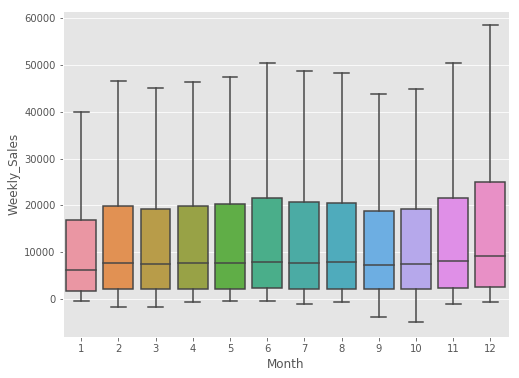

In [0]:
data = pd.concat([train['Month'], train['Weekly_Sales']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Month', y="Weekly_Sales", data=data, showfliers=False)

**Not much affect of months on Weekly Sales**

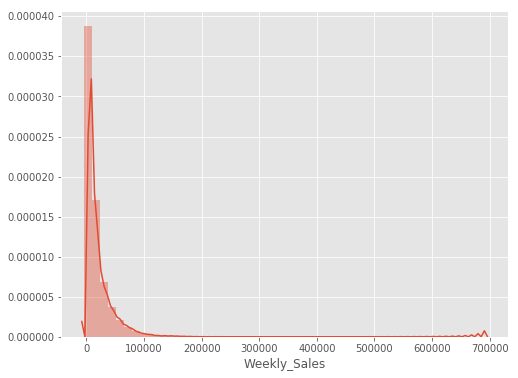

In [0]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['Weekly_Sales'])

**PDF of Weekly Sales is very much skewed.**

In [0]:
#Dropping markdown data as most of it is null
train                = train.drop(['CPI','Unemployment','Date',
                                       'MarkDown1','MarkDown2','MarkDown3', 
                                       'MarkDown4','MarkDown5','Weekly_Sales'],axis=1)
                                       
test                 = test.drop(['CPI','Unemployment','Date',
                                      'MarkDown1','MarkDown2','MarkDown3',
                                      'MarkDown4','MarkDown5'],axis=1)

In [10]:
train.head()

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,Year,Month,Day,Days,daysHoliday,logSales
0,1,1,False,1,151315,42.31,2.572,2010,2,5,65,0,10.306099
1,1,2,False,1,151315,42.31,2.572,2010,2,5,65,0,10.925853
2,1,3,False,1,151315,42.31,2.572,2010,2,5,65,0,9.837888
3,1,4,False,1,151315,42.31,2.572,2010,2,5,65,0,10.713173
4,1,5,False,1,151315,42.31,2.572,2010,2,5,65,0,10.524585


## Random Forest Regressor.

In [0]:
#https://github.com/leandromferreira/Kaggle-Walmart-Recruiting-Store-Sales-Forecasting

rf    = RandomForestRegressor(n_estimators=1500,min_samples_split=2,n_jobs=4)
#The file which contains sales for test data
result = open('result.csv','w')
result.write('Id,Weekly_Sales\n')
size = sam['Id'].count() #test size
i=0;

#Here for every row in sample file i.e for every dept store data we will fit our model separetly and predict sales.
while (i < size):

       Id           = sam['Id'][i]
       tmpStr       = Id.split('_')
       Store        = int(tmpStr[0])				                #Store ID
       Dept         = int(tmpStr[1])				                #Dept ID 
       dataF1       = train.loc[train['Dept']==Dept]				#Get the data from Dept  ID from all data
       tmpDf        = dataF1.loc[dataF1['Store']==Store]			#Get the data form Store ID from the filtring data 
       store_cnt        = tmpDf['Store'].count()
       dept_cnt	    = dataF1['Dept'].count()	
       tmpF         = dataF1.loc[train['IsHoliday']==1]
       dataF1       = pd.concat([dataF1,tmpF*4])		          	#Reforcing holiday data
       dataF2       = dataF1.loc[dataF1['Store']==Store]      		#Filtring 
       testF1       = test.loc[test['Dept']==Dept]		      		
       testF1       = testF1.loc[testF1['Store']==Store]
       testRows     = testF1['Store'].count()
       k            = i + testRows
		
       if (store_cnt < 10) and (dept_cnt!=0): #When the number of dataframe stores is too small RF fails then we will only work with department data
          y=np.asarray(dataF1['logSales'], dtype="|S6")
          X_train, X_test, y_train, y_test = train_test_split(dataF1.drop(['logSales'],axis=1),y)       
          
          trained_model  = rf.fit(dataF1.drop(['logSales'],axis=1),np.asarray(dataF1['logSales'],dtype=float))
       else:

          y=np.asarray(dataF2['logSales'], dtype="|S6")
          X_train, X_test, y_train, y_test = train_test_split(dataF2.drop(['logSales'],axis=1),y)          
          trained_model  = rf.fit(dataF2.drop(['logSales'],axis=1),np.asarray(dataF2['logSales'],dtype=float))
          
       tmpP_RF_Submiss      = ( np.exp(pd.to_numeric(trained_model.predict(testF1))) - 4990 )
      
       for j in range(i,k):                               
           result.write('%s,%s\n'%(sam['Id'][j],tmpP_RF_Submiss[j-i]))
       i+=testRows       
       print (i)
result.close()


## Extra Tree Regressor.

In [0]:
#https://github.com/leandromferreira/Kaggle-Walmart-Recruiting-Store-Sales-Forecasting

etr = ExtraTreesRegressor(n_estimators=1000, verbose=0, n_jobs=4)

#The file which contains sales for test data
result = open('result_etr.csv','w')
result.write('Id,Weekly_Sales\n')
size = sam['Id'].count() #test size
i=0;

#Here for every row in sample file i.e for every dept store data we will fit our model separetly and predict sales.
while (i < size):

       Id           = sam['Id'][i]
       tmpStr       = Id.split('_')
       Store        = int(tmpStr[0])				                #Store ID
       Dept         = int(tmpStr[1])				                #Dept ID 
       dataF1       = train.loc[train['Dept']==Dept]				#Get the data from Dept  ID from all data
       tmpDf        = dataF1.loc[dataF1['Store']==Store]			#Get the data form Store ID from the filtring data 
       store_cnt        = tmpDf['Store'].count()
       dept_cnt	    = dataF1['Dept'].count()	
       tmpF         = dataF1.loc[train['IsHoliday']==1]
       dataF1       = pd.concat([dataF1,tmpF*4])		          	#Reforcing holiday data
       dataF2       = dataF1.loc[dataF1['Store']==Store]      		#Filtring 
       testF1       = test.loc[test['Dept']==Dept]		      		
       testF1       = testF1.loc[testF1['Store']==Store]
       testRows     = testF1['Store'].count()
       k            = i + testRows
		
       if (store_cnt < 10) and (dept_cnt!=0): #When the number of dataframe stores is too small RF fails then we will only work with department data
          y=np.asarray(dataF1['logSales'], dtype="|S6")
          X_train, X_test, y_train, y_test = train_test_split(dataF1.drop(['logSales'],axis=1),y)       
          
          trained_model  = etr.fit(dataF1.drop(['logSales'],axis=1),np.asarray(dataF1['logSales'],dtype=float))
       else:

          y=np.asarray(dataF2['logSales'], dtype="|S6")
          X_train, X_test, y_train, y_test = train_test_split(dataF2.drop(['logSales'],axis=1),y)          
          trained_model  = etr.fit(dataF2.drop(['logSales'],axis=1),np.asarray(dataF2['logSales'],dtype=float))
          
       tmpP_RF_Submiss      = ( np.exp(pd.to_numeric(trained_model.predict(testF1))) - 4990 )
      
       for j in range(i,k):                               
           result.write('%s,%s\n'%(sam['Id'][j],tmpP_RF_Submiss[j-i]))
       i+=testRows       
       print (i)
result.close()


In [0]:
sam1=pd.read_csv('/content/result_etr.csv')
sam2=pd.read_csv('/content/result.csv')

In [0]:
sampleSubmission=pd.read_csv('/content/sampleSubmission.csv.zip')
sampleSubmission['Weekly_Sales']=0.7*sam1.Weekly_Sales+0.3*sam2.Weekly_Sales

In [0]:
sampleSubmission.to_csv('final.csv',index=False)

In [32]:
sampleSubmission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,34502.625217
1,1_1_2012-11-09,22044.460868
2,1_1_2012-11-16,24519.970368
3,1_1_2012-11-23,22703.645054
4,1_1_2012-11-30,26838.565374


#Conclusions:



```
The most important Features are days, year, isHoliday, Store, Dept.
```

```
Using only store dept and previous year sales we can build the model which can give good score.
```


```
Tree based methods like RandomForest And Extra Trees Regressor were used to predict sales.
```


```
Both base models alone gave public score below 2800 on LB.
```


```
Finally both the model results were combined using weightage average to reduce score further.
Finaly achieved score is 2732 and 2882 on public and private LB respectively.
```




